### References:

https://arxiv.org/abs/1312.6114  
https://habrahabr.ru/post/331552//  
https://blog.keras.io/building-autoencoders-in-keras.html  
https://keras.io/getting-started/functional-api-guide/  

In [26]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import os

from keras.layers import Input, Dense, Lambda, BatchNormalization, Dropout, Flatten, Reshape
from keras.optimizers import Adam, RMSprop
from keras.models import Model
from keras import backend as K
import tensorflow as tf
from keras import metrics, losses, objectives
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.callbacks import Callback
from IPython.display import Image as IPyImage

In [27]:
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.09
config.gpu_options.visible_device_list = '1'
set_session(tf.Session(config=config))

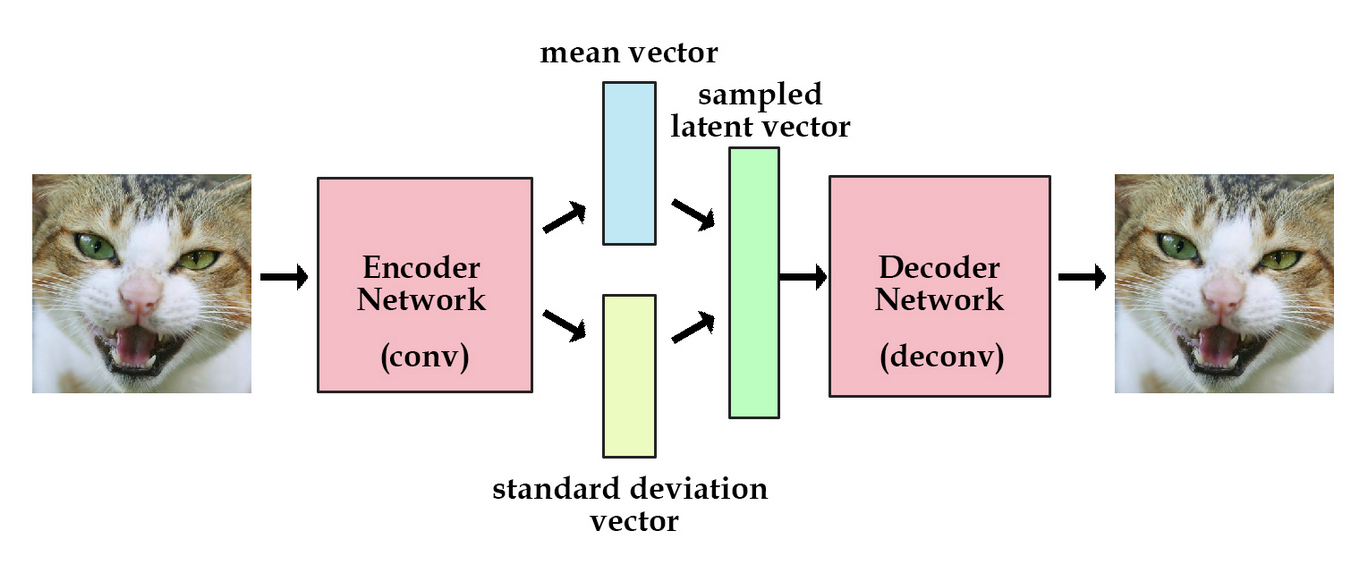

In [40]:
IPyImage(filename = "/home/gas/Pictures/Screenshot from 2018-03-02 16-54-09.png", width=1000, height=1000)

### Reparameterization trick:

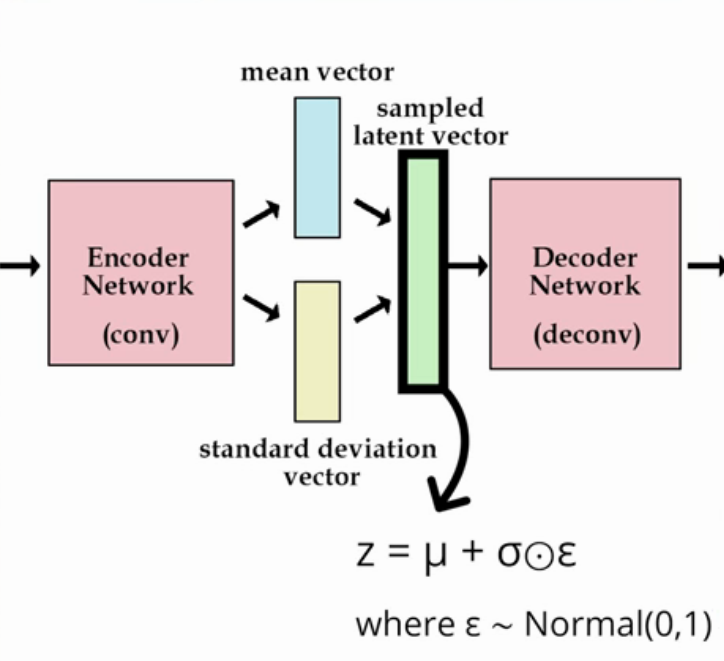

In [42]:
IPyImage(filename = "/home/gas/Pictures/Screenshot from 2018-03-16 17-47-49.png", width=500, height=500)

### Loss = reconstuction loss + kullback–leibler divergence:

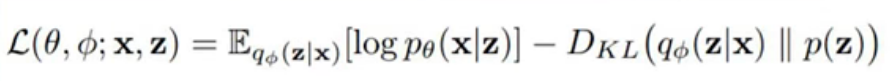

In [38]:
IPyImage(filename = "/home/gas/Pictures/Screenshot from 2018-03-16 17-40-31.png", width=500, height=500)

In [28]:
from IPython.display import clear_output

class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.grid(True)
        plt.legend()
        
        plt.show()
        
plot = PlotLearning()

In [29]:
def flat_plot_clusters(encoder):
    x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(6, 6))
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
    plt.colorbar()
    plt.show()

In [30]:
def plot_manifold(generator, n=15, image_size=(28, 28)):
    figure = np.zeros((image_size[0] * n, image_size[1] * n))
    grid_x = np.linspace(-15, 15, n)
    grid_y = np.linspace(-15, 15, n)

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]]) * noise_std
            x_decoded = generator.predict(z_sample)
            digit = x_decoded[0].reshape(image_size[0], image_size[1])
            figure[i * image_size[0]: (i + 1) * image_size[0],
                   j * image_size[1]: (j + 1) * image_size[1]] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='gray')
    plt.show()

In [105]:
def generate_image(generator, image_size, *args):
    z_sample = np.array([args]) * noise_std
    x_decoded = generator.predict(z_sample)
    pic = x_decoded[0].reshape(image_size[0], image_size[1], image_size[2])
    return pic

### Simple VAE model:

In [38]:
batch_size = 100
latent_dim = 2
intermediate_dim = 256
epochs = 100
img_size = (28,28,1)
original_dim = np.prod(img_size[:2])
noise_std = 1.0
start_lr = 0.0001

In [39]:
def vae_mlp_simple():
    x = Input(batch_shape=(batch_size, original_dim))
    h = Dense(intermediate_dim, activation='relu')(x)
    z_mean = Dense(latent_dim)(h)
    z_log_sigma = Dense(latent_dim)(h)

    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=noise_std)
        return z_mean + K.exp(z_log_sigma / 2) * epsilon
    
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

    decoder_h = Dense(intermediate_dim, activation='relu')
    decoder_mean = Dense(original_dim, activation='sigmoid')
    h_decoded = decoder_h(z)
    x_decoded_mean = decoder_mean(h_decoded)

    # end-to-end autoencoder
    vae = Model(x, x_decoded_mean)

    # encoder, from inputs to latent space
    encoder = Model(x, z_mean)
    encoder.summary()

    # generator, from latent space to reconstructed inputs
    decoder_input = Input(shape=(latent_dim,))
    _h_decoded = decoder_h(decoder_input)
    _x_decoded_mean = decoder_mean(_h_decoded)
    generator = Model(decoder_input, _x_decoded_mean)
    generator.summary()

    def vae_loss(x, decoded):
        xent_loss = original_dim*objectives.binary_crossentropy(x, decoded)
        kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
        return (xent_loss + kl_loss)/2/original_dim

    vae.compile(optimizer=Adam(start_lr), loss=vae_loss)
    
    return vae, encoder, generator

In [40]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [41]:
vae, encoder, generator = vae_mlp_simple()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (100, 784)                0         
_________________________________________________________________
dense_8 (Dense)              (100, 256)                200960    
_________________________________________________________________
dense_9 (Dense)              (100, 2)                  514       
Total params: 201,474
Trainable params: 201,474
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_11 (Dense)             multiple                  768       
_________________________________________________________________
dens

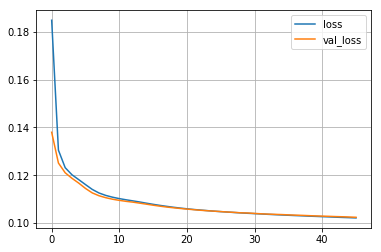

Epoch 47/100
  100/60000 [..............................] - ETA: 4s - loss: 0.0980

KeyboardInterrupt: 

In [42]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[plot])

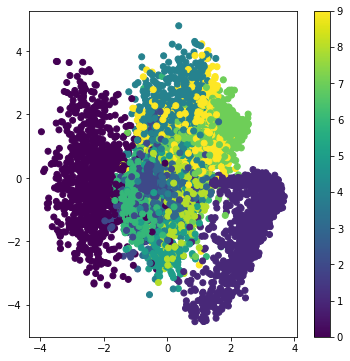

In [43]:
flat_plot_clusters(encoder)

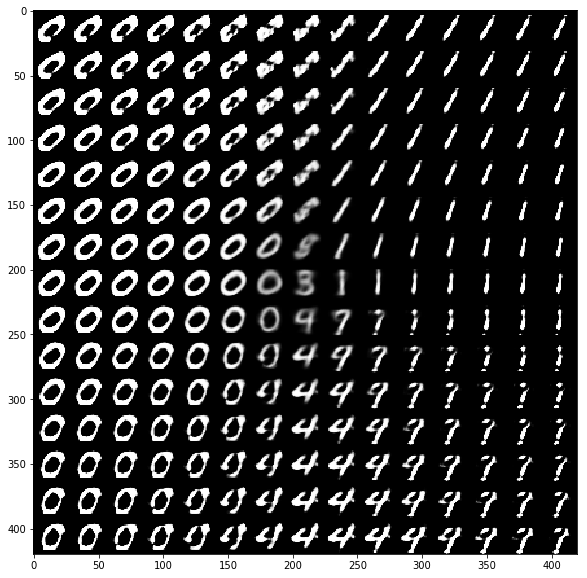

In [44]:
plot_manifold(generator, n=15, image_size=img_size)

### VAE model with regularization and couple tricks:

In [46]:
batch_size = 500
latent_dim = 2
dropout_rate = 0.3
start_lr = 0.0001
img_size = (28, 28, 1)
epochs = 100
noise_std = 1.0
original_dim = np.prod(img_size[:2])

In [47]:
def vae_mpl_upgraded():
    models = {}

    def apply_bn_and_dropout(x):
        return Dropout(dropout_rate)(BatchNormalization()(x))

    #Encoder
    input_img = Input(batch_shape=(batch_size, img_size[0], img_size[1], img_size[2]))
    x = Flatten()(input_img)
    x = Dense(256, activation='relu')(x)
    x = apply_bn_and_dropout(x)
    x = Dense(128, activation='relu')(x)
    x = apply_bn_and_dropout(x)

    z_mean = Dense(latent_dim)(x)
    z_log_sigma = Dense(latent_dim)(x)
    
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=noise_std)
        return z_mean + K.exp(z_log_sigma / 2) * epsilon

    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

    models["encoder"]  = Model(input_img, l, 'Encoder') 
    models["z_meaner"] = Model(input_img, z_mean, 'Enc_z_mean')
    models["z_lvarer"] = Model(input_img, z_log_sigma, 'Enc_z_log_sigma')
    models["encoder"].summary()

    #Decoder
    z = Input(shape=(latent_dim, ))
    x = Dense(128)(z)
    x = LeakyReLU()(x)
    x = apply_bn_and_dropout(x)
    x = Dense(256)(x)
    x = LeakyReLU()(x)
    x = apply_bn_and_dropout(x)
    x = Dense(original_dim, activation='sigmoid')(x)
    decoded = Reshape((img_size[0], img_size[1], img_size[2]))(x)

    models["decoder"] = Model(z, decoded, name='Decoder')
    models["vae"]     = Model(input_img, models["decoder"](models["encoder"](input_img)), name="VAE")
    models["decoder"].summary()
    
    def vae_loss(x, decoded):
        x = K.reshape(x, shape=(batch_size, original_dim))
        decoded = K.reshape(decoded, shape=(batch_size, original_dim))
        xent_loss = original_dim*objectives.binary_crossentropy(x, decoded)
        kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
        return (xent_loss + kl_loss)/2/original_dim
    
    models["vae"].compile(optimizer=Adam(start_lr), loss=vae_loss)
    
    return models

In [48]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

In [49]:
models = vae_mpl_upgraded()
vae = models["vae"]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (500, 28, 28, 1)     0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (500, 784)           0           input_5[0][0]                    
__________________________________________________________________________________________________
dense_13 (Dense)                (500, 256)           200960      flatten_2[0][0]                  
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (500, 256)           1024        dense_13[0][0]                   
__________________________________________________________________________________________________
dropout_5 

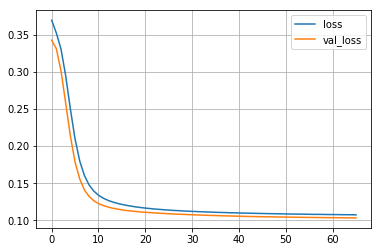

Epoch 67/100
10000/60000 [====>.........................] - ETA: 1s - loss: 0.1073

KeyboardInterrupt: 

In [50]:
vae.fit(x_train, x_train, shuffle=True, epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[plot])

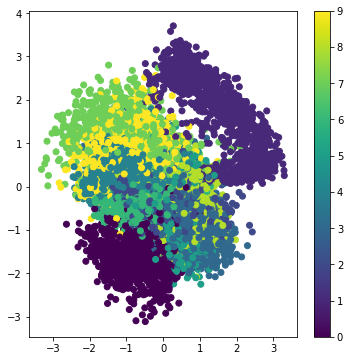

In [51]:
flat_plot_clusters(models['encoder'])

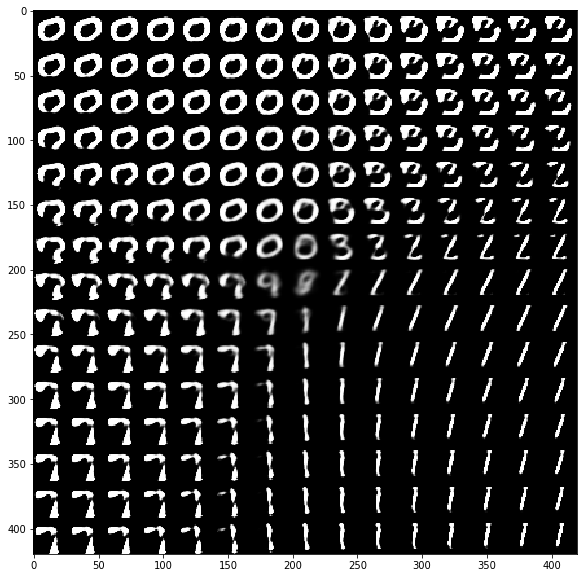

In [52]:
plot_manifold(models["decoder"], n=15, image_size=img_size)

### Frey faces example:

In [53]:
from ipywidgets import FloatSlider, interact
import os
from urllib.request import urlopen, URLError, HTTPError
from scipy.io import loadmat

In [54]:
%matplotlib inline

In [55]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [56]:
def fetch_file(url):
    """Downloads a file from a URL.
    """
    try:
        f = urlopen(url)
        print("Downloading data file " + url + " ...")

        # Open our local file for writing
        with open(os.path.basename(url), "wb") as local_file:
            local_file.write(f.read())
        print("Done.")
        
    except HTTPError as e:
        print("HTTP Error:", e.code, url)
    except URLError as e:
        print("URL Error:", e.reason, url)
        
url =  "http://www.cs.nyu.edu/~roweis/data/frey_rawface.mat"
data_filename = os.path.basename(url)
if not os.path.exists(data_filename):
    fetch_file(url)
else:
    print("Data file %s exists." % data_filename)

Data file frey_rawface.mat exists.


In [61]:
# reshape data for later convenience
img_size = (28, 20, 1)
ff = loadmat(data_filename, squeeze_me=True, struct_as_record=False)
ff = ff["ff"].T.reshape((-img_size[2], img_size[0], img_size[1]))

In [65]:
np.random.seed(42)
n_pixels = np.prod(img_size[:2])
X_train = ff[:1800]
X_val = ff[1800:1900]
X_train = X_train.astype('float32') / 255.
X_val = X_val.astype('float32') / 255.

# X_train = X_train.reshape((len(X_train), n_pixels))
# X_val = X_val.reshape((len(X_val), n_pixels))

X_train = np.reshape(X_train, (len(X_train), img_size[0], img_size[1], 1))
X_val  = np.reshape(X_val,  (len(X_val), img_size[0], img_size[1], 1))

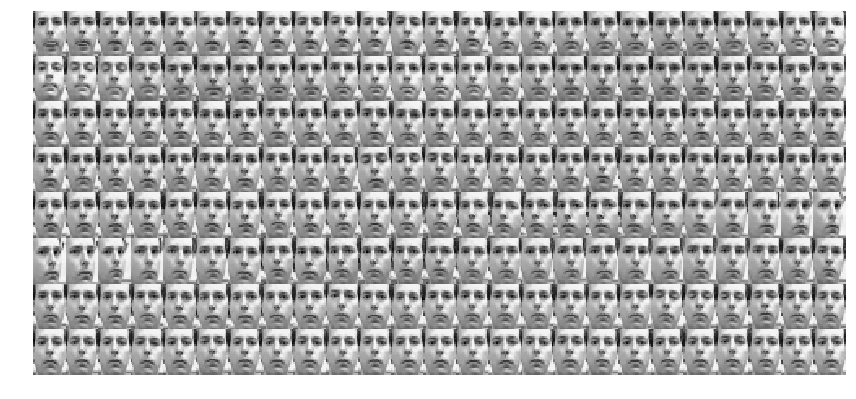

In [63]:
def show_examples(data, n=None, n_cols=20, thumbnail_cb=None):
    if n is None:
        n = len(data)    
    n_rows = int(np.ceil(n / float(n_cols)))
    figure = np.zeros((img_size[0] * n_rows, img_size[1] * n_cols))
    for k, x in enumerate(data[:n]):
        r = k // n_cols
        c = k % n_cols
        figure[r * img_size[0]: (r + 1) * img_size[0],
               c * img_size[1]: (c + 1) * img_size[1]] = x
        if thumbnail_cb is not None:
            thumbnail_cb(locals())
        
    plt.figure(figsize=(12, 10))
    plt.imshow(figure, cmap='gray')
    plt.axis("off")
    plt.tight_layout()
    
show_examples(ff, n=200, n_cols=25)

In [66]:
batch_size = 100
latent_dim = 2
dropout_rate = 0.3
start_lr = 0.0001
epochs = 100
noise_std = 1.0
original_dim = n_pixels

In [67]:
models = vae_mpl_upgraded()
vae = models["vae"]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (100, 28, 20, 1)     0                                            
__________________________________________________________________________________________________
flatten_3 (Flatten)             (100, 560)           0           input_7[0][0]                    
__________________________________________________________________________________________________
dense_20 (Dense)                (100, 256)           143616      flatten_3[0][0]                  
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (100, 256)           1024        dense_20[0][0]                   
__________________________________________________________________________________________________
dropout_9 

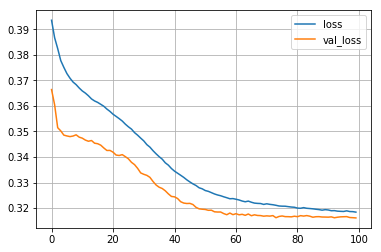

In [68]:
vae.fit(X_train, X_train, shuffle=True, epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, X_val),
        callbacks=[plot])

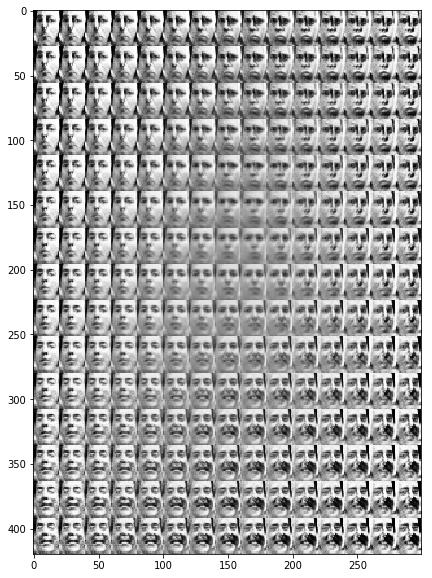

In [69]:
plot_manifold(models["decoder"], n=15, image_size=img_size)

In [72]:
humour = FloatSlider(min=-15, max=15, step=3, value=0)
pose = FloatSlider(min=-15, max=15, step=3, value=0)

@interact(humour=humour, pose=pose)
def do_thumb(pose, humour):
    z_sample = np.array([[humour, pose]]) * noise_std
    x_decoded = models["decoder"].predict(z_sample)
    face = x_decoded[0].reshape(img_size[0], img_size[1])
    plt.figure(figsize=(4, 4))
    ax = plt.subplot(111)
    ax.imshow(face, cmap='gray')
    plt.axis("off")

interactive(children=(FloatSlider(value=0.0, description='pose', max=15.0, min=-15.0, step=3.0), FloatSlider(value=0.0, description='humour', max=15.0, min=-15.0, step=3.0), Output()), _dom_classes=('widget-interact',))

In [73]:
pic = generate_image(models["decoder"], (28, 20, 1), -1,-2)

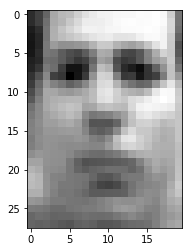

In [74]:
plt.imshow(pic, cmap='gray')

### Celeb A dataset:

In [10]:
!pip3 install sklearn

    100% |████████████████████████████████| 12.2MB 97kB/s eta 0:00:01   38% |████████████▎                   | 4.7MB 1.4MB/s eta 0:00:06    40% |█████████████                   | 4.9MB 1.1MB/s eta 0:00:07
  Running setup.py bdist_wheel for sklearn ... done
  Stored in directory: /root/.cache/pip/wheels/d7/db/a3/1b8041ab0be63b5c96c503df8e757cf205c2848cf9ef55f85e
Successfully built sklearn


In [75]:
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [1]:
def get_train_data(train_dir, image_size=64, trsh=50000):
    file_names = os.listdir(train_dir)
    np.random.shuffle(file_names)
    file_names = file_names[:trsh]
    images = np.zeros((len(file_names), image_size, image_size, 3)).astype(np.uint8)
    for ind, file_name in enumerate(tqdm(file_names)):
        file = train_dir + '/' + file_name
        image = Image.open(file)
        image = image.resize((image_size, image_size), Image.ANTIALIAS)
        images[ind] = np.asarray(image).astype(np.uint8)
    labels = []
    return images, labels

In [94]:
path = './data/img_align_celeba/'

In [95]:
images, labels = get_train_data(path, image_size=64, trsh=50000)

100%|██████████| 50000/50000 [01:19<00:00, 629.25it/s]


In [96]:
mean_image = np.mean(images, axis = 0)

In [97]:
def normalize(image):
    image = image.astype(np.int16)
    image_normalized = (image - mean_image) / 255
    return image_normalized 

images_normalized = np.array([normalize(image) for image in images])

In [98]:
indices = np.arange(len(images_normalized))
x_train, x_test, y_train, y_test, idx_train, idx_test = train_test_split(images_normalized, indices, test_size = 0.2)

In [99]:
x_test.shape

(10000, 64, 64, 3)

In [100]:
batch_size = 100
latent_dim = 2
dropout_rate = 0.3
start_lr = 0.0001
epochs = 100
noise_std = 1.0
img_size = (64, 64, 3)
original_dim = np.prod(img_size)

In [101]:
models = vae_mpl_upgraded()
vae = models["vae"]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (100, 64, 64, 3)     0                                            
__________________________________________________________________________________________________
flatten_7 (Flatten)             (100, 12288)         0           input_15[0][0]                   
__________________________________________________________________________________________________
dense_48 (Dense)                (100, 256)           3145984     flatten_7[0][0]                  
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (100, 256)           1024        dense_48[0][0]                   
__________________________________________________________________________________________________
dropout_25

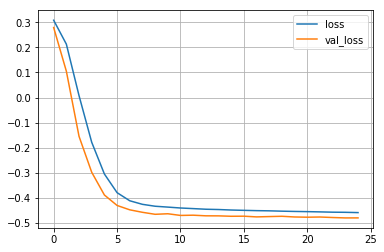

Epoch 26/100
15500/40000 [==========>...................] - ETA: 6s - loss: -0.4579

KeyboardInterrupt: 

In [102]:
vae.fit(x_train, x_train, shuffle=True, epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[plot])

In [109]:
pic = generate_image(models["decoder"], (64, 64, 3), -10,-20)

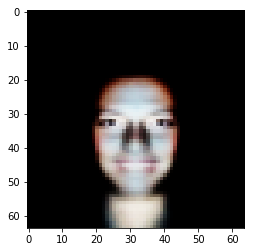

In [111]:
plt.imshow(pic)
plt.show()